The following code provides statistical analysis of both the training dataset.

In [220]:
%matplotlib inline
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Step 1. Upload data

In [221]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

### Step 2. Data analysis & Feature Engineering

In [222]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [223]:
train.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


In [224]:
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


#### 1. Interest Level -- map to (0, 1)
There's no missing value in 'interest_level'.

In [225]:
train.groupby('interest_level').size()

interest_level
high       3839
low       34284
medium    11229
dtype: int64

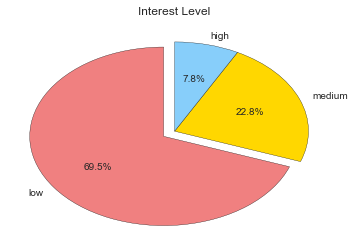

In [226]:
labels = ['low', 'medium', 'high']
sizes = train.interest_level.value_counts().values
explode = [0.1, 0, 0]
colors = ['lightcoral','gold','lightskyblue']
patches, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct="%1.1f%%",
                        startangle = 90)
plt.title('Interest Level')
plt.show()

Let's simplify the problem into a binary classification problem.

Since the low interest entries is a majority part of the dataset, we put high and medium interest entries together as one class
and low interest entries as another class so that the two classes have similar amount of entries.

In [227]:
train['interest_level'] = train['interest_level'].map({'high':1, 'medium':1, 'low':0})  
print(train.groupby('interest_level').size())

interest_level
0    34284
1    15068
dtype: int64


#### 2. manager_id, listing_id, building_id 
I'm not sure how these features will help with classification. Let's take a look at these features.

'manager_id'

In [228]:
unique, counts = np.unique(train['manager_id'], return_counts = True)
unique

array(['0000abd7518b94c35a90d64b56fbf3e6',
       '001ce808ce1720e24a9510e014c69707',
       '003fc4e9a70053082f131b1054966aaf', ...,
       'ffb9eceeaa4d60da7b41cc8f0954cd50',
       'ffd3c60281949a5cd806030203a79558',
       'ffd7307e4924587b30ec014a95db1362'], dtype=object)

In [229]:
counts

array([ 12,  10,   1, ...,   2,   7, 115], dtype=int64)

In [230]:
len(unique)

3481

49352 entries only contains 3481 manager_id. That means multiple listing share one manager_id, as seen in counts.

Let's figure out these high profile managers.
Thank https://www.kaggle.com/poonaml/two-sigma-renthop-eda

In [299]:
managerDF = train.groupby(['manager_id', 'interest_level'])['manager_id'].count().unstack('interest_level').fillna(0)
managerDF["sum"]=managerDF.sum(axis=1)
x=managerDF[ (managerDF['sum'] > 80) & (managerDF['high'] > 30)]
managerDF.head()
x.sort_values("sum",inplace=True)
plt.title("High Profile Managers")
plt.xlabel("Counts")
plt.ylabel("Manager ID")
x = x[x.index != 'e6472c7237327dd3903b3d6f6a94515a']
x["sum"].plot(kind='barh',color="brown");

KeyError: 'manager_id'

'building_id'

In [231]:
unique, counts = np.unique(train['building_id'], return_counts=True)
unique

array(['0', '00005cb939f9986300d987652c933e15',
       '00024d77a43f0606f926e2312513845c', ...,
       'ffe55387cd931c117ee1b8446f21953b',
       'fff0a02ad82421c226c6d6765a0dde57',
       'fff5915444b98b72a44a9456901f083c'], dtype=object)

In [232]:
counts

array([8286,    1,    3, ...,    1,    1,    2], dtype=int64)

In [233]:
len(unique)

7585

49352 entries only contains 7585 building_id. That means multiple listing share one building_id, as seen in counts.

Let's figure out these high profile buildi. Thank https://www.kaggle.com/poonaml/two-sigma-renthop-eda

In [ ]:
buildingDF = train.groupby(['building_id', 'interest_level'])['building_id'].count().unstack('interest_level').fillna(0)
buildingDF["sum"]=buildingDF.sum(axis=1)
x=buildingDF[ (buildingDF['sum'] > 60) & (buildingDF['high'] > 15)]
buildingDF.head()
#removing the outlier
x = x[x.index != '0']
x.sort_values("sum",inplace=True)
plt.title("High Profile Buildings")
plt.xlabel("Counts")
plt.ylabel("Building ID")
x["sum"].plot(kind='barh',color="orange")

'listing_id'

In [235]:
unique, counts = np.unique(train['listing_id'], return_counts = True)
unique

array([6811957, 6811965, 6811966, ..., 7742670, 7742803, 7753784], dtype=int64)

In [236]:
counts

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [237]:
len(unique)

49352

49352 entries only contains 49352 listing_id. That means each listing contains one unique listing_id, as seen in counts.

Little information may be drawn from these listing_id. Let's drop them for now.

In [238]:
train.drop(['listing_id'], inplace = True, axis = 1)

#### 3. Lattitude & Longitude -- delete outliers, clustering into 15 groups

Let's first visualize the location distribution of these rental apartments.

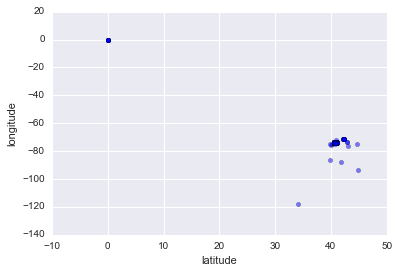

In [239]:
plt.scatter(train['latitude'], train['longitude'], alpha = 0.5)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

The latitude and longitude coordinates of new york city are 40.730610, -73.935242. Let's say we commute 150 miles along all 
directions, corresponds to ~2.4 degree in latitude and ~3 degree in longitude. That expands the lattitude to 40.73+/-2.4 and longitude to -73.94 +/- 3. Data outside of this range are outliers needed to be removed. We further narrow down our focus to simplify the problem.

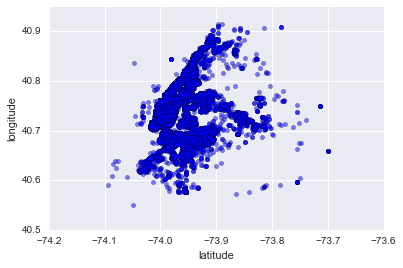

In [240]:
train = train[(train['longitude'] < -73.70) & (train['longitude'] > -74.10) & (train['latitude'] > 40.30) & 
              (train['latitude'] < 40.95)]

plt.scatter(train['longitude'], train['latitude'], c = 'b', alpha = 0.5)
plt.xlabel('latitude')
plt.ylabel('longitude')

Next, let's used unsupervised K-means clustering method to divide the addresses into different categories.

I'm not sure about the optimum number of clusters. So let's first use elbow method to figure out the best number of clusters.

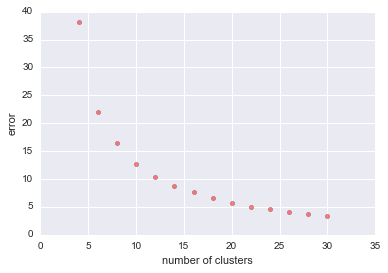

In [241]:
from sklearn.cluster import KMeans

num_cluster = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
coord = []
labels = []
error = []
for k in num_cluster:
    X = np.array((train['latitude'], train['longitude']))
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X.T)
    Z = kmeans.cluster_centers_
    labels.append(kmeans.labels_)
    coord.append(Z)    
    error.append(kmeans.inertia_) 

plt.scatter(num_cluster, error, c = 'r', alpha = 0.5)
plt.xlabel('number of clusters')
plt.ylabel('error')
plt.show()


There is no sharp elbow in the above curve, so let's choose n_cluster = 10 as an initial try.

Let's plot the centroids on top of the location distribution map.

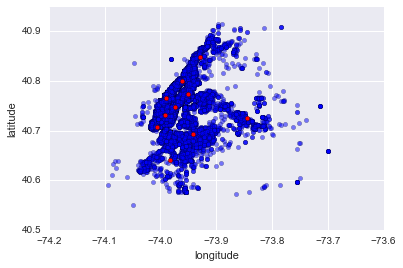

In [242]:
X, Y = [], []
for i in range(10):
    X.append(coord[3][i][1])
    Y.append(coord[3][i][0])

plt.scatter(train['longitude'], train['latitude'], c = 'b', alpha = 0.5)
plt.scatter(X, Y, c = 'r')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Next, let's change the address into 10 binary categories.

In [243]:
N = len(labels[3])
train = train.set_index([[i for i in range(N)]])
Y = pd.Series(labels[3])

def process_loglat():    
    global train, Y
    loc_dummies = pd.get_dummies(Y, prefix='loglat')
    train = pd.concat([train,loc_dummies], axis = 1)
    
process_loglat()

#### 4. price -- delete outliers, only consider [300, 20000] range

In [244]:
train['price'].describe()

count    4.929100e+04
mean     3.829786e+03
std      2.207974e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

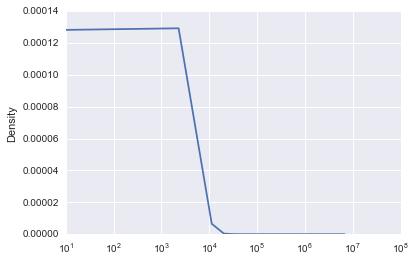

In [245]:
train['price'].plot(logx = True, logy = False, xlim = [10, 10e7], kind = 'kde')
plt.show()

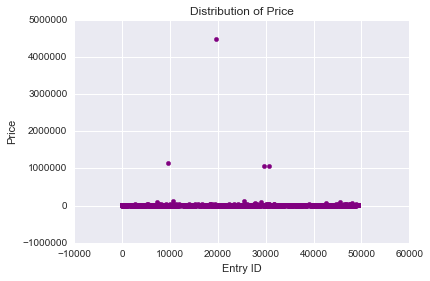

In [246]:
plt.scatter(range(train.shape[0]), train['price'].values,color='purple')
plt.title("Distribution of Price")
plt.xlabel("Entry ID")
plt.ylabel("Price")

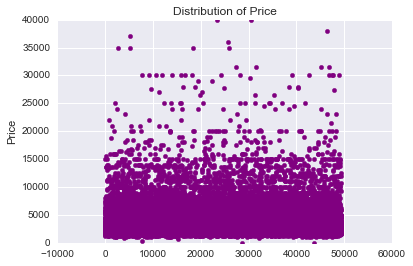

In [247]:
plt.scatter(range(train.shape[0]), train['price'].values, color = 'purple')
plt.ylim(0, 40000)
plt.ylabel('Price')
plt.title('Distribution of Price')

In [248]:
train[train['price'] > 20000]['price'].count()

107

In [249]:
train[train['price'] < 300]['price'].count()

2

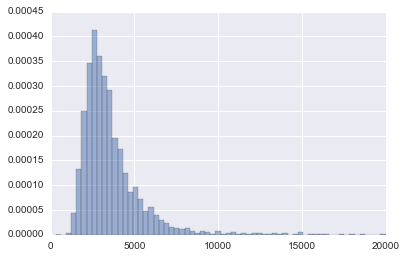

In [250]:
train['price'].hist(bins=64, range=(300, 20000), alpha = .5, normed = True)
plt.show()

In [251]:
train = train[(train['price'] >= 300) & (train['price'] <= 20000)]
train = train.set_index([[i for i in range(49182)]])

#### 5. bedrooms & bathrooms -- delete outliers (those with too many bathrooms)

Let's first visualize distribution of bedrooms and bathrooms.

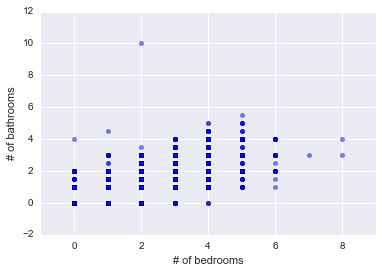

In [252]:
plt.scatter(train['bedrooms'], train['bathrooms'], alpha = 0.5)
plt.xlabel('# of bedrooms')
plt.ylabel('# of bathrooms')
plt.show()

Some rooms have 0 bedroom and 0 bathrooms or more than one bathrooms, while some have 2 bedrooms and over 10 bathrooms. These are probably 
mistakes in the original posts. Let's take a look at these data and take out the outliers.

In [253]:
train[(train['bathrooms'] == 0) & (train['bedrooms'] == 0)].head(5)

,bathrooms,bedrooms,created,description,display_address,features,interest_level,latitude,longitude,photos,...,loglat_0,loglat_1,loglat_2,loglat_3,loglat_4,loglat_5,loglat_6,loglat_7,loglat_8,loglat_9
239,0.0,0,2016-06-12 14:12:49,,46th Street,[],0,40.6503,-74.0135,[https://photos.renthop.com/2/7153130_8a050b70...,...,0,0,0,0,0,0,1,0,0,0
299,0.0,0,2016-04-07 02:49:51,"Enjoy the great restaurants, clubs, boutiques ...",408 East 92nd Street,"[Fitness Center, Indoor Pool, Residents Lounge...",0,40.7805,-73.9464,[https://photos.renthop.com/2/6837641_bb020a11...,...,0,0,1,0,0,0,0,0,0,0
480,0.0,0,2016-04-05 02:49:40,Amidst the vibrant energy of the West Village ...,10 Downing Street,"[Fitness Center, Doorman, Laundry in Building,...",0,40.7295,-74.0029,[https://photos.renthop.com/2/6823888_b59ff1b0...,...,0,0,0,0,0,0,0,0,0,1
678,0.0,0,2016-04-22 02:50:22,SpaciousA StudioA Apartment in Modern New Deve...,1465 Fifth Avenue,"[WiFi Access, Live-in Super, Laundry in Buildi...",0,40.8021,-73.9450,[https://photos.renthop.com/2/6910673_937d4a17...,...,0,0,0,0,0,0,0,0,1,0
1376,0.0,0,2016-04-16 04:35:39,West Village Studio. Amenities: 24hr ...,Christopher Street,[],0,40.7328,-74.0089,[https://photos.renthop.com/2/6883576_ec94a36d...,...,0,0,0,0,0,0,0,0,0,1


In [254]:
train[(train['bathrooms'] == 0) & (train['bedrooms'] == 0)].describe()

,bathrooms,bedrooms,interest_level,latitude,longitude,price,loglat_0,loglat_1,loglat_2,loglat_3,loglat_4,loglat_5,loglat_6,loglat_7,loglat_8,loglat_9
count,154.0,154.0,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.0,0.0,0.032468,40.754457,-73.971949,2926.331169,0.058442,0.194805,0.233766,0.006494,0.103896,0.077922,0.038961,0.019481,0.116883,0.149351
std,0.0,0.0,0.177817,0.044080,0.028446,1585.750321,0.235342,0.397343,0.424606,0.080582,0.306121,0.268923,0.194133,0.138657,0.322329,0.357597
min,0.0,0.0,0.000000,40.622900,-74.034600,868.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,40.732800,-73.992900,2261.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,40.749100,-73.976400,2592.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.000000,40.777450,-73.953300,2995.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,0.0,1.000000,40.865400,-73.835100,15000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Most of the lists with 0 bedrooms and 0 bathrooms have low interest level.

Let's see where they are located.

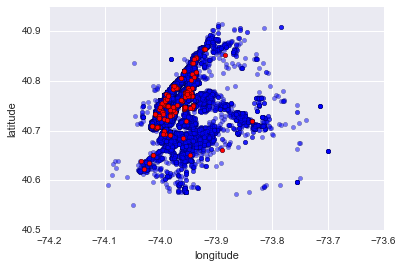

In [255]:
bed0_bath0 = train[(train['bathrooms'] == 0) & (train['bedrooms'] == 0)]
plt.scatter(train['longitude'], train['latitude'], c = 'b', alpha = 0.5)
plt.scatter(bed0_bath0['longitude'], bed0_bath0['latitude'], c = 'r')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Most 0 bedroom and 0 bathroom apartments are located on Manhattan, which may make sense given Manhanttan is very crowded and expensive. But still, very few people may rent an apartment without either bedroom or bathroom. Let's take these data out. Entries with too many bathrooms (number of bathrooms > number of bedrooms + 1) is also taken out.

In [257]:
train['bath-bed'] = train['bathrooms'] - train['bedrooms']
train = train[(train['bath-bed'] <= 1) & ~((train['bathrooms'] == 0) & (train['bedrooms'] == 0))]
train.drop(['bath-bed'], inplace = True, axis = 1)
train = train.set_index([[i for i in range(48970)]])

Let's plot the new # of bedrooms versus # of bathrooms, which is more reasonable.

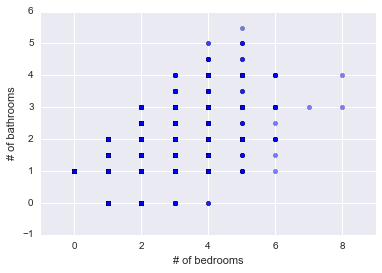

In [258]:
plt.scatter(train['bedrooms'], train['bathrooms'], alpha = 0.5)
plt.xlabel('# of bedrooms')
plt.ylabel('# of bathrooms')
plt.show()

#### 6. features -- categorize by important features

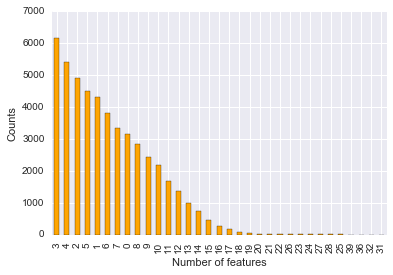

In [259]:
train['num_features'] = train['features'].apply(len)
train.num_features.value_counts().plot(kind='bar',color='orange')
plt.xlabel("Number of features")
plt.ylabel("Counts")

#### 7. features -- categorize by important descriptions
Let's first extract important features from the training dataset.

In [261]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import itertools

vectorizer = CountVectorizer(min_df=1)
x = vectorizer.fit_transform(itertools.chain.from_iterable(train['features']))

names = vectorizer.get_feature_names()
counts = np.sum(x.toarray(), axis=0)
n2c = list(zip(names, counts))
n2c.sort(key=lambda x: x[1], reverse=True)
print(n2c)

[('allowed', 45410), ('laundry', 29554), ('in', 29516), ('elevator', 26057), ('hardwood', 24527), ('floors', 23470), ('cats', 23419), ('dogs', 21917), ('doorman', 20971), ('dishwasher', 20727), ('building', 19221), ('fee', 18685), ('no', 18046), ('fitness', 13272), ('center', 13166), ('unit', 9777), ('war', 9167), ('pre', 9121), ('space', 7580), ('outdoor', 7210), ('deck', 7023), ('roof', 6987), ('room', 6151), ('high', 5116), ('dining', 5100), ('internet', 4305), ('speed', 4303), ('pool', 3097), ('balcony', 3090), ('swimming', 2722), ('new', 2659), ('construction', 2602), ('terrace', 2354), ('garden', 2095), ('loft', 2084), ('exclusive', 2083), ('patio', 2065), ('common', 1528), ('access', 1425), ('wheelchair', 1377), ('prewar', 1361), ('garage', 1005), ('fireplace', 939), ('simplex', 908), ('lowrise', 789), ('private', 743), ('parking', 732), ('reduced', 699), ('furnished', 683), ('on', 679), ('level', 622), ('multi', 621), ('ceilings', 615), ('live', 602), ('site', 532), ('renovated

Let's print out some unique terms containing high frequency terms: ('laundry', 29648), ('elevator', 26134), ('hardwood', 24575), 
('cats', 23471), ('dogs', 21968), ('doorman', 21061), ('dishwasher', 20775), ('fitness', 13311).

In [262]:
import re

def uniq_term(name):
    global train
    terms = set()
    for x in train['features']:
        for phrase in x:
            phrase_lc = phrase.strip().lower()
            if re.search(name, phrase_lc):
                terms.add(phrase_lc)
        
    unique_terms = sorted(terms)
    for term in unique_terms:
        print(term)
        
uniq_term('laundry')

**laundry room code is 3401
air conditioned laundry facility
elevator & laundry
elevator/laundry/ so close to the 6 $2450!!
garage fitness facility laundry room valet lounge billiards room rooftop deck wifi access
laundry
laundry & housekeeping
laundry & housekeeping • marc club includes a cinema room
laundry / dry-cleaning and auto care
laundry facility on every floor
laundry hookup
laundry in basement
laundry in bldg
laundry in bldg.
laundry in building
laundry in building!
laundry in some units
laundry in unit
laundry on every floor
laundry on floor
laundry room
laundry room as well as housekeeping & dry-cleaning services
laundry room on every floor. health club
laundry.
on-site laundry
private laundry room on every floor
spotless laundry
valet laundry


In [263]:
uniq_term('elevator')

elevator
elevator & laundry
elevator building
elevator/laundry/ so close to the 6 $2450!!
high speed elevator
keyed elevator with direct access into your living room
rent stabilize - elevator building


In [264]:
uniq_term('hardwood')

and stainless steel appliances with a dishwasher well maintained hardwood floors add to the warmth and modern feel of the space.
boating hardwood floors
exposed brickhardwood floors microwaverenovated open view excellent
hardwood
hardwood  floors
hardwood floor
hardwood flooring
hardwood flooring throughout
hardwood floors
no fee hardwood floors
polished hardwood floors
redwood hardwood floor


In [265]:
uniq_term('cats')

* marvelous midtown gem * spacious sundrenched studio * stunning prewar details * cats ok **
** chic chelsea find! * massive 4br home * 2 full baths * chef inspired kitchen * elev that opens into apt * cats ok **
** classy conv 2br duplex dream! * room to entertain * lndry bldg * cats ok * heart of the village **
** lex ave luxury! * sprawling sunfilled 1br home * all utilities incl! * doorman * elev/lndry bldg * cats ok **
** pristine modern townhouse! * massive 2br home * chef inspired kitchen * huge windows galore * cats ok **
** super sweet 1br home * elegant e60s! * mr clean approved * chef inspired kitchen * tons of natural light! * cats ok **
** w60s wonder ~ near the park! * overszed studio steal * courtyard * free gym * elev/lndry bldg * cats ok **
cats allowed
cats on approval
pets: cats only
pets: cats/small dogs


In [266]:
uniq_term('dogs')

dogs allowed
dogs ok
dogs under 20 lbs.                parking ( additional fee)
pets: cats/small dogs
pre-war small dogs
small dogs ok


In [267]:
uniq_term('doorman')

** holy deal batman!! * oversized 3br mansion * 2 full baths * huge scenic terrace * doorman * elev/lndry bldg * roof deck * real pix **
** lex ave luxury! * sprawling sunfilled 1br home * all utilities incl! * doorman * elev/lndry bldg * cats ok **
** midtown mansion * sprawling sunfilled studio * utilities included * doorman * elev/lndry bldg * pets ok **
24 hour doorman
24 hour doorman concierge
24 hr doorman
24-hour concierge and doorman
24-hour doorman
24/7 doorman
24/7 doorman concierge
24/7 full-time doorman concierge
24hr doorman
24hr white-gloved doorman
doorman
ft doorman
full-time doorman
no fee...luxury doorman building^^^river views
part-time doorman
twenty-four hour concierge and doorman
twenty-four-hour concierge and doorman
virtual doorman
• on-site lifestyle concierge by luxury attaché •24/7 doorman • state of the art cardiovascular and weight training equipment • 24-hour valet parking garage • valet services including dry cleaning


In [268]:
uniq_term('dishwasher')

** brownstone beauty * massive 2br home * steps to the park * ss kitchen * dishwasher * oversized closets * near columbia u **
** court square gem! * lic luxury 2br home * ss kitchen ~ dishwasher * bay windows * fireplace * all new! **
** court square gem! * sprawling sundrenched 2br home * custom finishes * dishwasher * fireplaces * eat-in kitchen * bay windows **
** diamond uws deal! * massive studio * exposed brick * dishwasher * pets ok * steps to the park! **
** elegant e50s & park baby! * massive 4br mansion * no broker fee * dishwasher * walls of windows * elev bldg **
** elegant e50s!! * sprawling sundrenched 2br home * french drs * breakfast bar * dishwasher * eat-in kitchen * walk-in closets! **
** eye popping no fee! * massive 1br home * exposed brick * private terrace * dishwasher * elev bldg * roof deck * pets ok **
** holy no fee deal! * oversized 2br super share * private terrace * ss kitchen * dishwasher * elev/lndry bldg * 3 blks to l train **
** holy no fee! * oversiz

In [269]:
uniq_term('fitness')

000 sf fitness center
24/7 fitness center
a wide array of complimentary fitness classes offered weekly
concierge service. fitness center
featuring a sophisticated precor® online profile system that tracks your personal fitness goals
fitness center
fitness center and health club
fitness facility
fitness room
fully equipped fitness center with studio for classes
fully-equipped club fitness center
garage fitness facility laundry room valet lounge billiards room rooftop deck wifi access
gym fitness lounge swimming pool sun decks exercise studios indoor half-basketball court
gym/fitness
residents-only fitness center and aerobic room professionally outfitted with a full complement of strength and cardio-training equipment
state of the art fitness center
state-of-the-art cardio and fitness club
state-of-the-art fitness center
state-of-the-art fitness center and even an on-site dog run
two level fitness center


In [270]:
class Feature:
    def __init__(self):
        self.laundry = 0
        self.elevator = 0
        self.hardwood = 0
        self.cats = 0
        self.dogs = 0
        self.doorman = 0
        self.dishwasher = 0
        self.fitness = 0

In [271]:
features_list = []

for x in train['features']:
    f = Feature()
    features_list.append(f)
    for phrase in x:
        phrase_lc = phrase.strip().lower()
        if re.search('laundry', phrase_lc):
            f.laundry = 1
        if re.search('elevator', phrase_lc):
            f.elevator = 1
        if re.search('hardwood', phrase_lc):
            f.hardwood = 1
        if re.search('cats', phrase_lc):
            f.cats = 1
        if re.search('dogs', phrase_lc):
            f.dogs = 1
        if re.search('doorman', phrase_lc):
            f.doorman = 1
        if re.search('dishwasher', phrase_lc):
            f.dishwasher = 1
        if re.search('fitness', phrase_lc):
            f.fitness = 1

laundry_ = [f.laundry for f in features_list]  
elevator_ = [f.elevator for f in features_list]
hardwood_ = [f.hardwood for f in features_list]
cats_ = [f.cats for f in features_list]
dogs_ = [f.dogs for f in features_list]
doorman_ = [f.doorman for f in features_list]
dishwasher_ = [f.dishwasher for f in features_list]
fitness_ = [f.fitness for f in features_list]

train['laundry'] = laundry_
train['elevator'] = elevator_
train['hardwood'] = hardwood_
train['cats'] = cats_
train['dogs'] = dogs_        
train['doorman'] = doorman_        
train['dishwasher'] = dishwasher_
train['fitness'] = fitness_                   

In [272]:
train = train.drop(['features'], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48970 entries, 0 to 48969
Data columns (total 30 columns):
bathrooms          48970 non-null float64
bedrooms           48970 non-null int64
created            48970 non-null object
description        48970 non-null object
display_address    48970 non-null object
interest_level     48970 non-null int64
latitude           48970 non-null float64
longitude          48970 non-null float64
photos             48970 non-null object
price              48970 non-null int64
street_address     48970 non-null object
loglat_0           48970 non-null uint8
loglat_1           48970 non-null uint8
loglat_2           48970 non-null uint8
loglat_3           48970 non-null uint8
loglat_4           48970 non-null uint8
loglat_5           48970 non-null uint8
loglat_6           48970 non-null uint8
loglat_7           48970 non-null uint8
loglat_8           48970 non-null uint8
loglat_9           48970 non-null uint8
num_features       48970 non-null int64


#### 7. created -- categorize by time and date
Change 'created' timeframe into numerical values, check distribution, divide into multiple categories

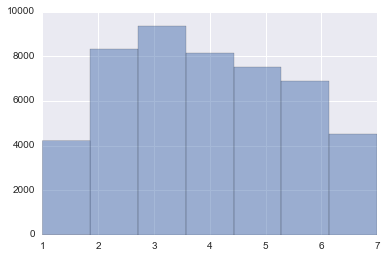

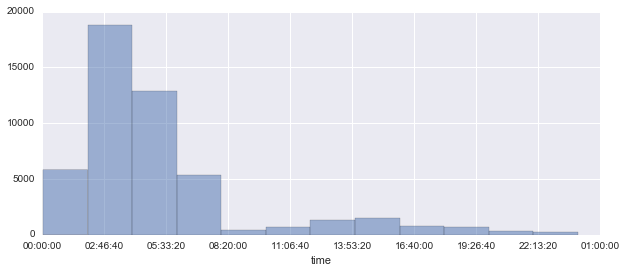

In [273]:
from datetime import time
from datetime import timezone
import datetime

times = pd.to_datetime(train['created']) # object to datetime64[ns]

train['dayofweek'] = [t.isoweekday() for t in times]
train['timeofday'] = [t.time() for t in times]

train['dayofweek'].hist(bins = 7, figsize = (6, 4), alpha = 0.5)
plt.show()

train['timeofday'].hist(bins = 12, figsize= (10, 4), alpha = 0.5) # 1-8 am most
plt.show()

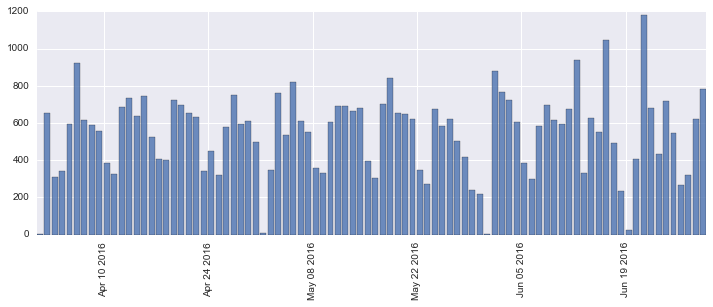

In [274]:
train["created"] = pd.to_datetime(train["created"])
train["date_created"] = train["created"].dt.date
cnt_srs = train['date_created'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

Plot day of week versus interest level.

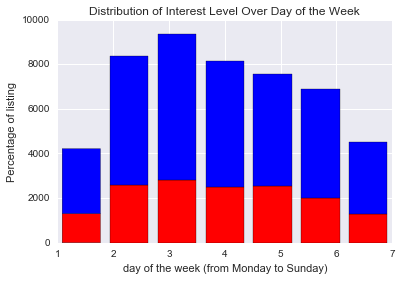

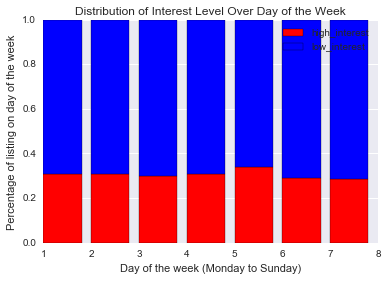

In [275]:
from datetime import datetime

figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['interest_level'] == 1]['dayofweek'], train[train['interest_level'] == 0]['dayofweek']], stacked = True,\
         bins = 7, color = ['r', 'b'], label = ['high interest','low interest'], log = False)
    
plt.xlabel('day of the week (from Monday to Sunday)')
plt.ylabel('Percentage of listing')
#plt.legend()
plt.title("Distribution of Interest Level Over Day of the Week")
plt.show()


# stacked bar graph: Friday shows slightly higher interest compared to other days
c = train.groupby('dayofweek').size()  
c = c.tolist()

y1, y2 = [], []
for i in range(7):
    y1.append(train[(train['interest_level'] == 1) & (train['dayofweek'] == i + 1)]['dayofweek'].count()/float(c[i]))
    y2.append(train[(train['interest_level'] == 0) & (train['dayofweek'] == i + 1)]['dayofweek'].count()/float(c[i]))

x = [i+1 for i in range(7)]
figure = plt.figure(figsize = (6, 4))
p1 = plt.bar(x, y1, color = 'r')
p2 = plt.bar(x, y2, bottom = y1, color = 'b')
plt.xlabel('Day of the week (Monday to Sunday)')
plt.ylabel('Percentage of listing on day of the week')
plt.legend((p1[0], p2[0]), ('high_interest', 'low_interest'))
plt.title("Distribution of Interest Level Over Day of the Week")
plt.show()

It's clear that rental lists posted on Friday has slightly higher proportion of high interest compared to those posted on other days.

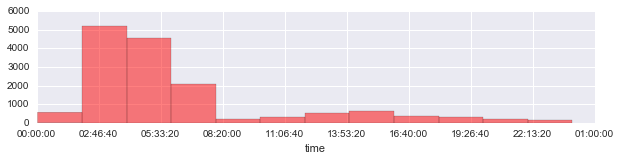

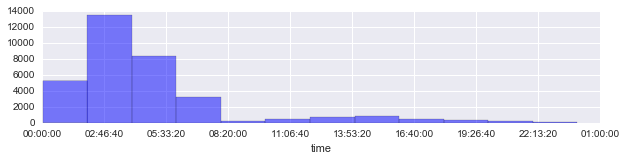

In [276]:
train[train['interest_level'] == 1]['timeofday'].hist(bins = 12, figsize = (10, 2), alpha = 0.5, color = 'r')
plt.show()

train[train['interest_level'] == 0]['timeofday'].hist(bins = 12, figsize = (10, 2), alpha = 0.5, color = 'b')
plt.show()

It's not clear how interest_level is correlated with the time of day the rental list was posted.
Let's plot the results using percentage instead of absolute counts.

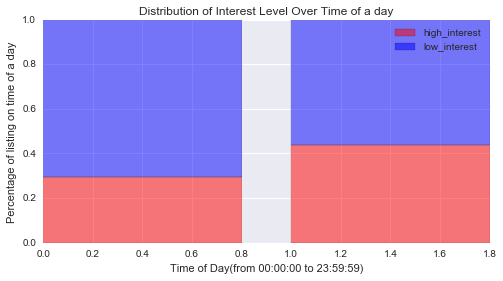

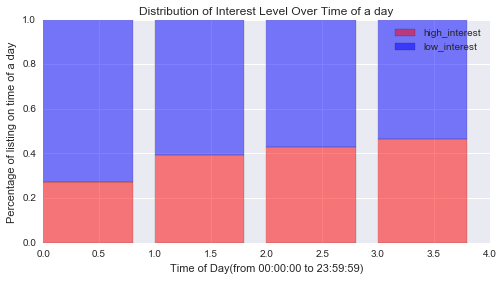

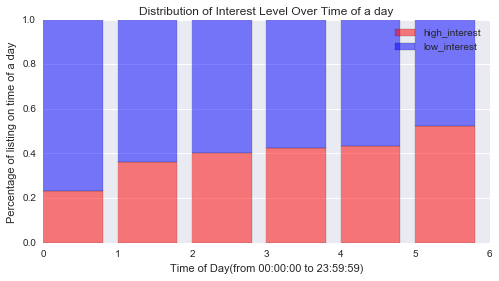

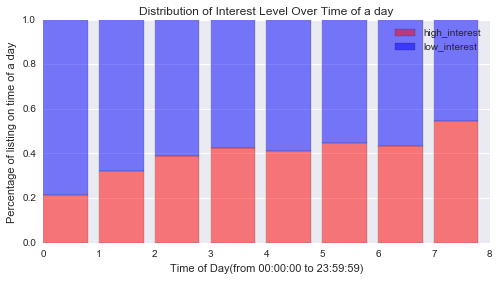

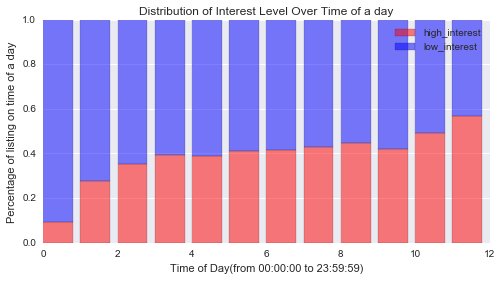

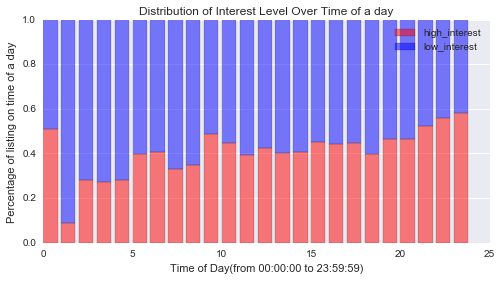

In [277]:
from datetime import datetime
slices = [2, 4, 6, 8, 12, 24]
for k in slices:
    t = []
    for i in range(k):
        temp = '5:00:00'
        temp = temp.replace('5', str(i*24//k))
        t.append(datetime.strptime(temp, '%H:%M:%S').time())
    t.append(datetime.strptime('23:59:59', '%H:%M:%S').time())

    c1, c2 = [], []
    for i in range(k-1):
        c1.append(train[(train['timeofday'] >= t[i]) & (train['timeofday'] < t[i+1]) & (train['interest_level'] == 1)]['timeofday'].count())
        c2.append(train[(train['timeofday'] >= t[i]) & (train['timeofday'] < t[i+1]) & (train['interest_level'] == 0)]['timeofday'].count())

    c1.append(train[(train['timeofday'] >= t[k-1]) & (train['timeofday'] < t[k]) & (train['interest_level'] == 1)]['timeofday'].count())
    c2.append(train[(train['timeofday'] >= t[k-1]) & (train['timeofday'] < t[k]) & (train['interest_level'] == 0)]['timeofday'].count())

    pct1, pct2 = [], []
    for i in range(k):
        temp = c1[i]/float(c1[i] + c2[i])
        pct1.append(temp)
        pct2.append(1.0 - temp)
    
    x = [i for i in range(k)]
    figure = plt.figure(figsize = (8, 4))
    p1 = plt.bar(x, pct1, color = 'r', alpha = 0.5)
    p2 = plt.bar(x, pct2, bottom = pct1, color = 'b', alpha = 0.5)
    plt.xlabel('Time of Day(from 00:00:00 to 23:59:59)')
    plt.ylabel('Percentage of listing on time of a day')
    plt.legend((p1[0], p2[0]), ('high_interest', 'low_interest'))
    plt.title("Distribution of Interest Level Over Time of a day")
    plt.show()

Apartment rental lists posted at different time of day indeed have attracted different interest. This may be related to people's 
daily schedule/activities and energy cycles. 

Let's separate Friday from the rest of the days and classify the time of day into four categories.

In [282]:
def process_dayofweek():
    
    global train
    # separate Friday and other days of week
    train['dayofweek'] = train['dayofweek'].map({1:1, 2:1, 3:1, 4:1, 6:1, 7:1, 5:0.0})

process_dayofweek()

In [283]:
def process_timeofday():    
    
    global train
    
    t = [datetime.strptime('00:00:00', '%H:%M:%S').time(), datetime.strptime('06:00:00', '%H:%M:%S').time(), 
         datetime.strptime('12:00:00', '%H:%M:%S').time(), datetime.strptime('18:00:00', '%H:%M:%S').time(), 
         datetime.strptime('23:59:59', '%H:%M:%S').time()]
    
    def mapping(x):
        if x >= t[0] and x < t[1]:
            return 0
        elif x >= t[1] and x < t[2]:
            return 1
        elif x >= t[2] and x < t[3]:
            return 2
        else:
            return 3
    
    times = pd.to_datetime(train['created']) # object to datetime64[ns]
    train['timeofday'] = [m.time() for m in times]
    train['timeofday'] = train['timeofday'].apply(mapping)
    
    timeofday_dummies = pd.get_dummies(train['timeofday'], prefix='timeofday')
    train = pd.concat([train,timeofday_dummies], axis = 1)
    train.drop(['timeofday'], axis = 1, inplace = True)
    
    
process_timeofday()    

#### 8. photo -- categorize by photo number

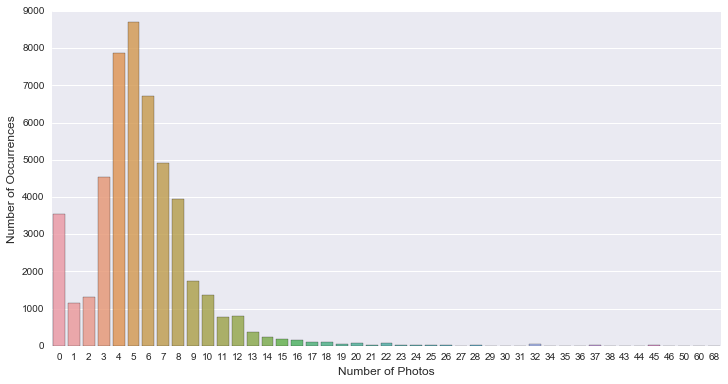

In [284]:
train["num_photos"] = train["photos"].apply(len)
cnt_srs = train['num_photos'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Replace the 'photo' column with 'photo_number' column.

In [285]:
photo_num = []
for i, x in train.iterrows():
        photo_num.append(len(x.photos))

train = train.assign(photo_number = photo_num)
train['photo_number'].describe()

count    48970.000000
mean         5.600735
std          3.614750
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         68.000000
Name: photo_number, dtype: float64

Plot photo_number versus interest level.

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


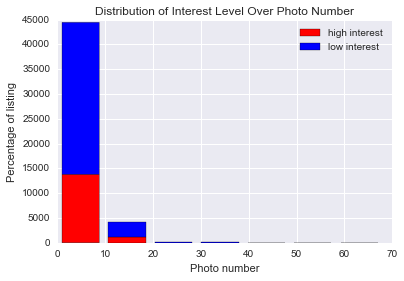

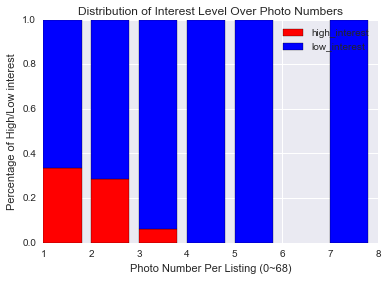

In [289]:
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['interest_level'] == 1]['photo_number'],train[train['interest_level'] == 0]['photo_number']], stacked = True, \
         color = ['r', 'b'], bins = 7, label = ['high interest','low interest'], log = False)
plt.xlabel('Photo number')
plt.ylabel('Percentage of listing')
plt.legend()
plt.title("Distribution of Interest Level Over Photo Number")

# stacked bar graph: Friday shows slightly higher interest compared to other days
# image > 30, no interest
y1, y2 = [], []
for i in range(7):
    temp1 = train[(train['interest_level'] == 1) & (train['photo_number'] > i*10) & (train['photo_number'] < (i+1)*10)]['photo_number'].count()
    temp2 = train[(train['interest_level'] == 0) & (train['photo_number'] > i*10) & (train['photo_number'] < (i+1)*10)]['photo_number'].count()
    y1.append(temp1*1.0/(temp1 + temp2))
    y2.append(temp2*1.0/(temp1 + temp2))
        
x = [i+1 for i in range(7)]
figure = plt.figure(figsize = (6, 4))
p1 = plt.bar(x, y1, color = 'r')
p2 = plt.bar(x, y2, bottom = y1, color = 'b')
plt.xlabel('Photo Number Per Listing (0~68)')
plt.ylabel('Percentage of High/Low interest')
plt.legend((p1[0], p2[0]), ('high_interest', 'low_interest'))
plt.title("Distribution of Interest Level Over Photo Numbers")
plt.show()

It is clear that the interest level is strongly correlated with the photo number of each posts. Thus we categorize the photo numbers by four classes: 0 ~10, 10~20, 20~30, >30.

In [291]:
def process_photo():
    
    global train
    
    photo = [0, 10, 20, 30]
    
    def mapping_photo(x):
        if x >= photo[0] and x < photo[1]:
            return 0
        elif x >= photo[1] and x < photo[2]:
            return 1
        elif x >= photo[2] and x < photo[3]:
            return 2
        else:
            return 3
        
    train['photo_number'] = train['photo_number'].apply(mapping_photo)
    
    
    photo_dummies = pd.get_dummies(train['photo_number'], prefix='photo_number')
    train = pd.concat([train,photo_dummies], axis = 1)

    train.drop('photo_number', axis = 1, inplace = True)
    
process_photo()

#### 9. decription -- categorize by length

Let's first extract the length of each description.

In [292]:
descrip_len = []
     
for i, x in train.iterrows():
        descrip_len.append(len(x.description.strip()))
train = train.assign(description_len = descrip_len)

Plot description lens versus interest level

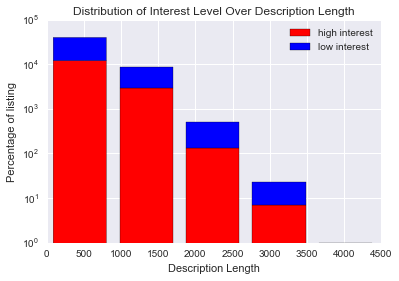

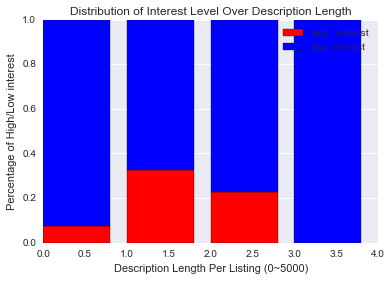

In [293]:
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['interest_level'] == 1]['description_len'],train[train['interest_level'] == 0]['description_len']], stacked = True, \
         color = ['r', 'b'], bins = 5, label = ['high interest','low interest'], log = True)
plt.xlabel('Description Length')
plt.ylabel('Percentage of listing')
plt.legend()
plt.title("Distribution of Interest Level Over Description Length")


y1, y2 = [], []
temp1 = train[(train['interest_level'] == 1) & (train['description_len'] == 0)]['description_len'].count()
temp2 = train[(train['interest_level'] == 0) & (train['description_len'] == 0)]['description_len'].count()
y1.append(temp1*1.0/(temp1 + temp2))
y2.append(temp2*1.0/(temp1 + temp2))
    
for i in range(3):
    temp1 = train[(train['interest_level'] == 1) & (train['description_len'] > i*2000) & (train['description_len'] <= (i+1)*2000)]['description_len'].count()
    temp2 = train[(train['interest_level'] == 0) & (train['description_len'] > i*2000) & (train['description_len'] <= (i+1)*2000)]['description_len'].count()
    y1.append(temp1*1.0/(temp1 + temp2))
    y2.append(temp2*1.0/(temp1 + temp2))
        
x = [i for i in range(4)]
figure = plt.figure(figsize = (6, 4))
p1 = plt.bar(x, y1, color = 'r')
p2 = plt.bar(x, y2, bottom = y1, color = 'b')
plt.xlabel('Description Length Per Listing (0~5000)')
plt.ylabel('Percentage of High/Low interest')
plt.legend((p1[0], p2[0]), ('high_interest', 'low_interest'))
plt.title("Distribution of Interest Level Over Description Length")
plt.show()

The interest level also show dependence on the length of the descriptions. Similarily, we categorize the description into four 
length based on their length (in terms of number of words).

In [295]:
def process_description():
    
    global train
    
    def mapping_description(x):
        if x == 0:
            return 0
        elif x > 0 and x <= 2000:
            return 1
        elif x > 2000 and x <= 4000:
            return 2
        else:
            return 3
        
    train['description_len'] = train['description_len'].apply(mapping_description)
    
    
    description_dummies = pd.get_dummies(train['description_len'], prefix='description_len')
    train = pd.concat([train, description_dummies], axis = 1)

    train.drop('description_len', axis = 1, inplace = True)
    
process_description()

#### 10. Display Address

Display_address that appear less than 2 times: 63.22%
Display_address that appear less than 10 times: 89.6%
Display_address that appear less than 50 times: 97.73%
Display_address that appear less than 100 times: 99.26%
Display_address that appear less than 500 times: 100.0%


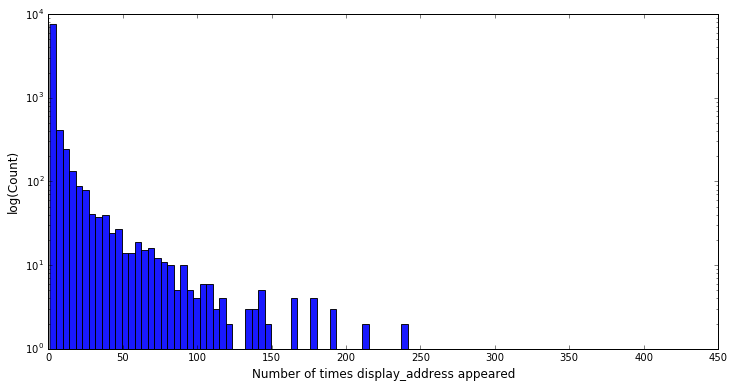

In [7]:
cnt_srs = train.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times: {}%'.format(i, round((cnt_srs < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_srs.values, bins=100, log=True, alpha=0.9)
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

Not sure how to feed display address information into machine learning algorithm. Drop this feature later.

#### 11. delete non-numerical columns

In [640]:
# delete object columns
train = train.drop(['display_address', 'street_address', 'photos', 'features', 'description', 'created'], axis=1)
train.dropna(axis = 0, how = 'any')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48910 entries, 0 to 48909
Data columns (total 41 columns):
bathrooms            48910 non-null float64
bedrooms             48910 non-null int64
interest_level       48910 non-null int64
price                48910 non-null int64
loglat_0             48910 non-null uint8
loglat_1             48910 non-null uint8
loglat_2             48910 non-null uint8
loglat_3             48910 non-null uint8
loglat_4             48910 non-null uint8
loglat_5             48910 non-null uint8
loglat_6             48910 non-null uint8
loglat_7             48910 non-null uint8
loglat_8             48910 non-null uint8
loglat_9             48910 non-null uint8
loglat_10            48910 non-null uint8
loglat_11            48910 non-null uint8
loglat_12            48910 non-null uint8
loglat_13            48910 non-null uint8
loglat_14            48910 non-null uint8
doorman              48910 non-null int64
elevator             48910 non-null int64
pet    

### Step 3. Building ML Algorithms

In [642]:
y = train['interest_level']
x = train.drop(['interest_level'], axis = 1)

ScaledLR: 0.730467 (0.006740)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("V

ScaledLDA: 0.708882 (0.006003)
ScaledKNN: 0.708590 (0.005325)
ScaledCART: 0.699039 (0.005810)
ScaledNB: 0.389025 (0.010902)
ScaledSVM: 0.727838 (0.007815)


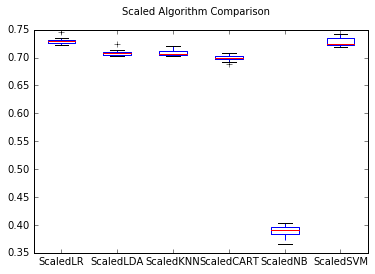

In [643]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

validation_size = 0.30
seed = 6
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size = validation_size, random_state = seed)
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

from sklearn.metrics import accuracy_score
results = []
names = []
scoring = 'accuracy'
num_folds = 10
seed = 7

for name, model in pipelines:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)    

# compare algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

AB: 0.741887 (0.004156)
GBM: 0.747378 (0.007945)
RF: 0.720858 (0.007604)


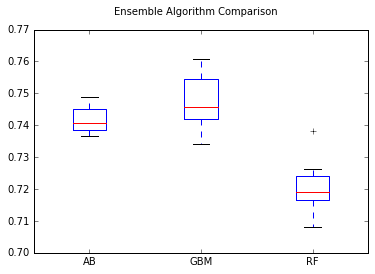

In [644]:
# ensemble methods 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" %(name, cv_results.mean(), cv_results.std())
    print(msg)

# compare algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
optional feature engineering:
train['num_photos'] = train['photos'].apply(len)
train['num_features'] = train['features'].apply(len)
train['num_description_words'] = train['description'].apply(lambda x: len(x.split(' ')))
train['num_description_len'] = train['description'].apply(len)

In [ ]:
other feature engineering:
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32156
TFIDF: short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important
    a word is to a document in a collection or corpus
nmf: non-negative matrix factorization, used for dimension reduction

In [ ]:
Feature engineering:
1, the smaller the listing_id, the sooner the creation time
Because the listing_id can reflect the creation of the order of time. Perhaps you can sort the creation time, and then use
the sorted order as a feature
interest level does disappear with larger values for listing_id

Some metadata from the images like avg RGB components, avg width/height, etc. And, of course, the leak (thanks to @KazAnova)
with 3 additional binary variables indicating time blocks of image creations (first 4 days, last day and the rest).

price_per_sqft:
A proxy for $/sqft and the interest on 1/2-baths
https://www.kaggle.com/arnaldcat/a-proxy-for-sqft-and-the-interest-on-1-2-baths
    
New Features from Addresses' Fields (The higher the difference between "display_address" and "street_address", higher the interest.)
https://www.kaggle.com/ivanoliveri/new-features-from-addresses-fields/notebook
    
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32146#178428
    
https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion/32148